# OptimizingDelivery Analysis

## Import libraries

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

from scipy.stats import randint, uniform


## Import Data

In [2]:
# Import directory
%store -r optimizingdelivery_data_dir

In [3]:
# Define dataframes and dataframe names
dataframe_names = ['customers', 'dates_2022', 'products', 'target_orders', 'order_lines', 'orders_aggregate']

In [4]:
# Function to import or reset dataframes
def import_reset():

    # Read parquet to import and if local instances exist then overwrite, effectively resetting the dataframes
    for name in dataframe_names:
        file_path = os.path.join(optimizingdelivery_data_dir, f'{name}.parquet')
        globals()[f'od_{name}'] = pd.read_parquet(file_path)

In [5]:
# Import dataframes
import_reset()

In [6]:
print(od_customers.shape)
print(od_dates_2022.shape)
print(od_products.shape)
print(od_target_orders.shape)
print(od_order_lines.shape)
print(od_orders_aggregate.shape)

(35, 3)
(365, 4)
(18, 3)
(35, 4)
(57096, 11)
(31729, 6)


## Exploration

In [7]:
od_order_lines.columns

Index(['order_id', 'order_placement_date', 'customer_id', 'product_id',
       'order_qty', 'agreed_delivery_date', 'actual_delivery_date',
       'delivery_qty', 'in_full', 'on_time', 'on_time_in_full'],
      dtype='object')

In [8]:
# Percentage of on time, in full, and on time in full deliveries
print('order_lines')
print('ot_pct: ' + str((od_order_lines['on_time'].sum() / len(od_order_lines)) * 100))
print('if_pct: ' + str((od_order_lines['in_full'].sum() / len(od_order_lines)) * 100))
print('otif_pct: ' + str((od_order_lines['on_time_in_full'].sum() / len(od_order_lines)) * 100))

order_lines
ot_pct: 71.11706599411517
if_pct: 65.96083788706738
otif_pct: 47.95432254448648


In [9]:
# Percentage of on time, in full, and on time in full deliveries
print('orders_aggregate')
print('ot_pct: ' + str((od_orders_aggregate['on_time'].sum() / len(od_orders_aggregate)) * 100))
print('if_pct: ' + str((od_orders_aggregate['in_full'].sum() / len(od_orders_aggregate)) * 100))
print('otif_pct: ' + str((od_orders_aggregate['otif'].sum() / len(od_orders_aggregate)) * 100))

orders_aggregate
ot_pct: 59.03117022282455
if_pct: 52.78136720350468
otif_pct: 29.020769642913425


In [10]:
od_order_lines.sample(5)

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,in_full,on_time,on_time_in_full
41735,FJUL715102602,2022-07-12,789102,25891602,107,2022-07-15,2022-07-16,96,0,0,0
4236,FMR317122202,2022-03-14,789122,25891202,264,2022-03-17,2022-03-18,251,0,0,0
46107,FJUL729101602,2022-07-26,789101,25891202,338,2022-07-29,2022-07-29,338,1,1,1
19681,FMY55103102,2022-05-02,789103,25891102,419,2022-05-05,2022-05-05,398,0,1,0
30068,FJUN65422601,2022-06-04,789422,25891203,111,2022-06-05,2022-06-06,105,0,0,0


In [11]:
# Calculate the mean percentages by customer
customer_split = od_order_lines.groupby('customer_id')[['in_full', 'on_time', 'on_time_in_full']].mean() * 100

# Reset index
customer_split = customer_split.reset_index().rename(columns={'in_full': 'if_pct',
                                                             'on_time': 'ot_pct', 
                                                             'on_time_in_full': 'otif_pct'})

# Round decimals to 2 decimal places
customer_split = customer_split.round(2)

In [12]:
customer_split.sample(5)

,customer_id,if_pct,ot_pct,otif_pct
18,789421,30.77,26.28,8.55
1,789102,73.70,82.62,60.34
23,789521,73.01,26.68,18.67
31,789720,74.11,82.93,61.26
25,789601,30.06,83.70,24.07


In [13]:
# Compare percentages to target percentages
customer_split = pd.merge(customer_split, od_target_orders, how='left', on='customer_id')

In [14]:
list(customer_split.columns)

['customer_id',
 'if_pct',
 'ot_pct',
 'otif_pct',
 'ontime_target%',
 'infull_target%',
 'otif_target%']

In [15]:
# Rename columsn for consistency
customer_split.rename(columns={ 'infull_target%': 'if_target_pct',
                                'ontime_target%': 'ot_target_pct', 
                                'otif_target%': 'otif_target_pct'}, inplace=True)

In [16]:
# Reorgnize columns for readability
customer_split = customer_split[['customer_id', 'if_pct', 'if_target_pct', 
                                 'ot_pct', 'ot_target_pct', 
                                 'otif_pct', 'otif_target_pct']]

In [17]:
customer_split.sample(5)

,customer_id,if_pct,if_target_pct,ot_pct,ot_target_pct,otif_pct,otif_target_pct
22,789520,29.37,68,28.16,75,7.92,51
0,789101,74.42,80,84.79,86,63.01,69
30,789703,75.88,78,85.38,85,64.68,66
31,789720,74.11,77,82.93,86,61.26,66
1,789102,73.70,81,82.62,90,60.34,73


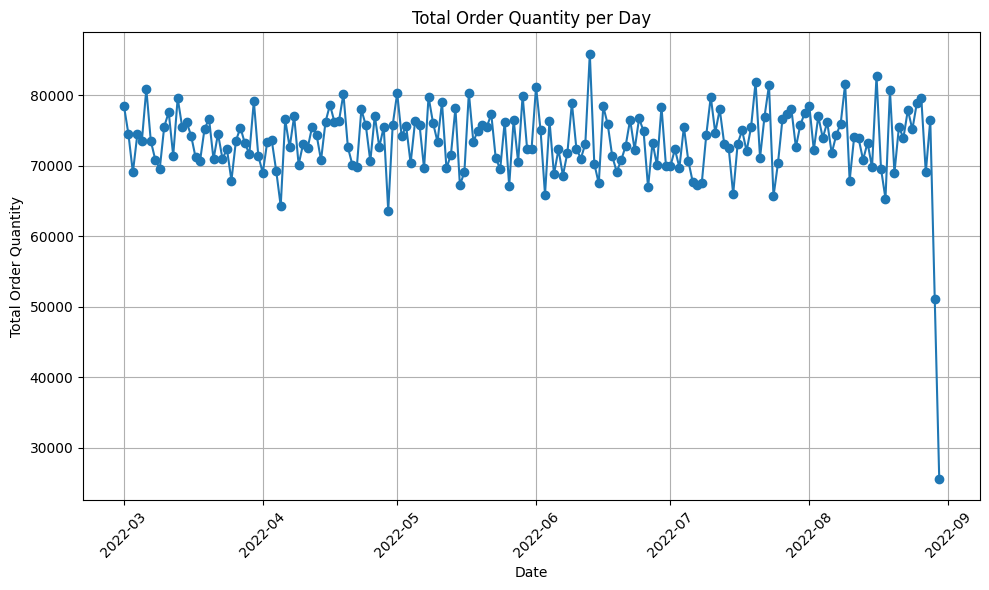

In [18]:
# Plot quantity ordered over time

# Group sum by date
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['order_qty'].sum()

# Plot
plt.figure(figsize=(10, 6))

plot_data.plot(marker='o', grid=True)

plt.title('Total Order Quantity per Day')
plt.xlabel('Date')
plt.ylabel('Total Order Quantity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

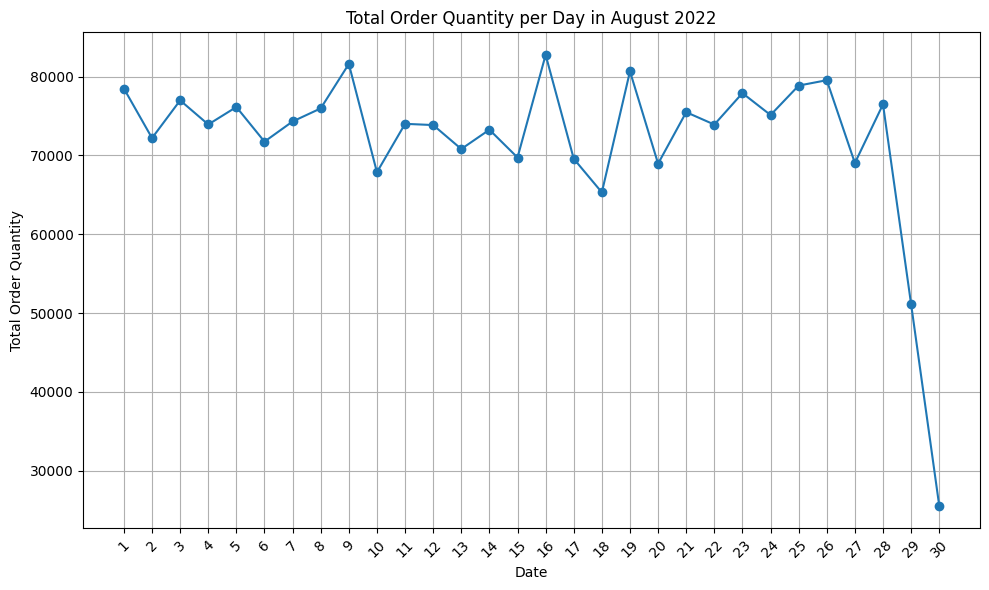

In [19]:
# Plot quantity ordered over time, highlight outliers in august

# Group sum by date
plot_data = od_order_lines[od_order_lines['order_placement_date'].dt.date > pd.to_datetime('2022-07-31').date()].groupby(od_order_lines['order_placement_date'].dt.day)['order_qty'].sum()

# Plot
plt.figure(figsize=(10, 6))

plot_data.plot(marker='o', grid=True)

plt.title('Total Order Quantity per Day in August 2022')
plt.xlabel('Date')
plt.ylabel('Total Order Quantity')
plt.xticks(rotation=45, ticks=plot_data.index)

plt.tight_layout()
plt.show()

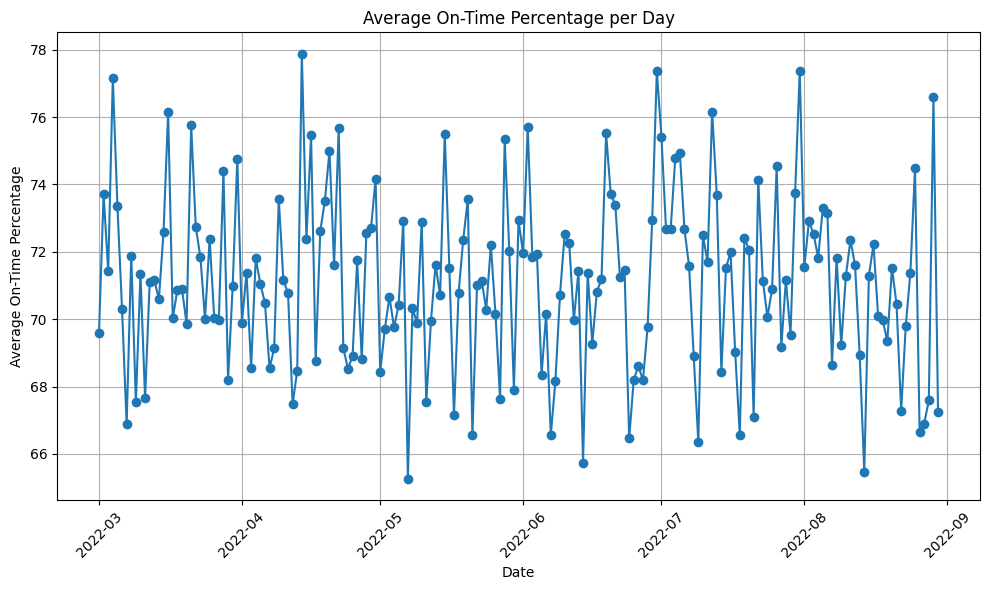

In [20]:
# Plot percent of deliveries that are on time over time

# Group percent on_time by date
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['on_time'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
plot_data.plot(marker='o', grid=True)

plt.title('Average On-Time Percentage per Day')
plt.xlabel('Date')
plt.ylabel('Average On-Time Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

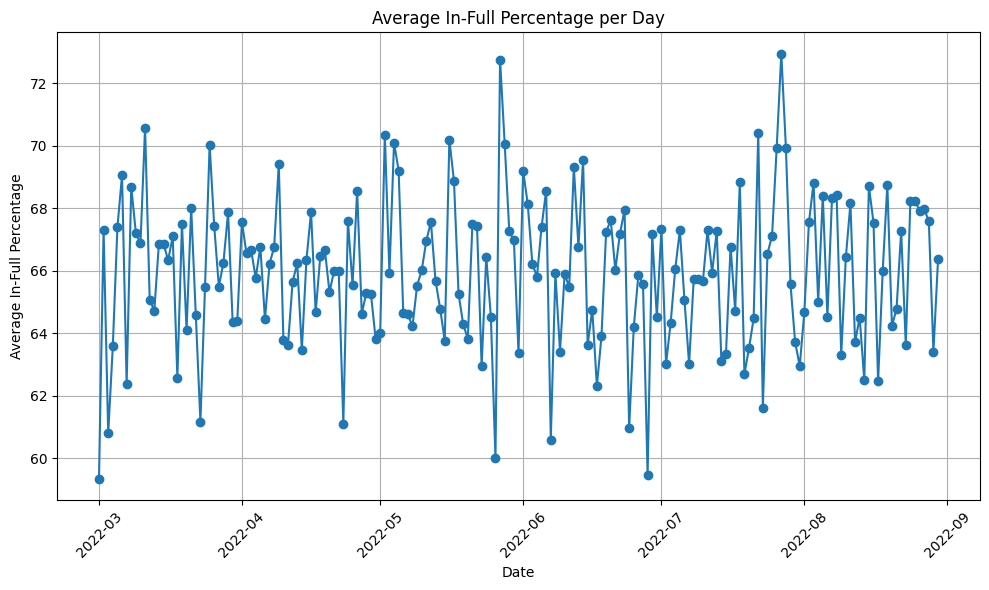

In [21]:
# Plot percent of deliveries that are in full over time

# Group percent in_full by date
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['in_full'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
plot_data.plot(marker='o', grid=True)

plt.title('Average In-Full Percentage per Day')
plt.xlabel('Date')
plt.ylabel('Average In-Full Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

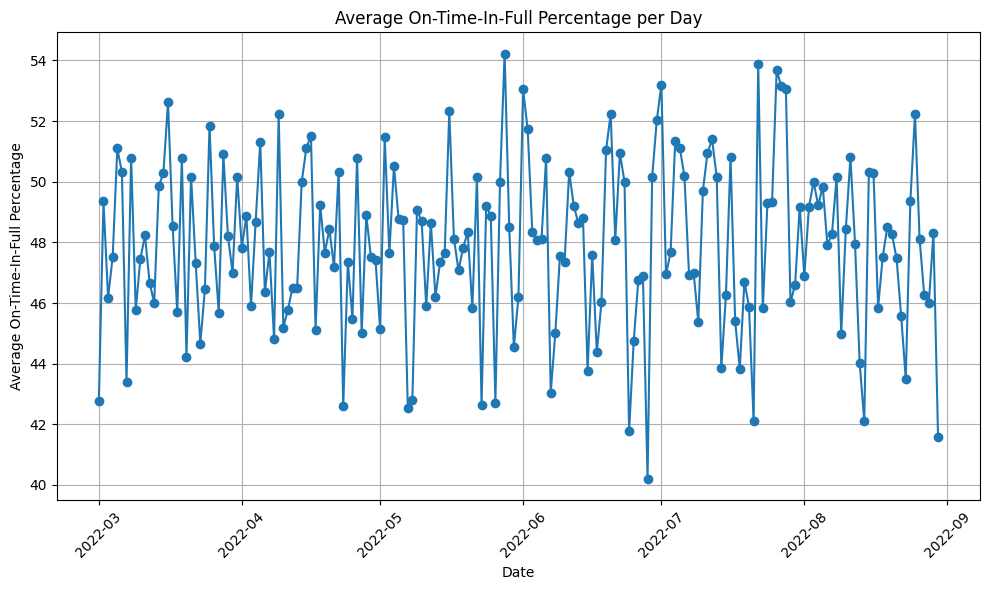

In [22]:
# Plot percent of deliveries that are on time and in full over time

# Group by date and calculate the mean of on_time_in_full for each day
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['on_time_in_full'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
plot_data.plot(marker='o', grid=True)

plt.title('Average On-Time-In-Full Percentage per Day')
plt.xlabel('Date')
plt.ylabel('Average On-Time-In-Full Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Machine Learning Model

##### Create Predictive Models:
  
Building predictive models to determine whether an order line meets targets like 'in_full', 'on_time', or 'otif' is a fundamental step. You can use various machine learning algorithms like logistic regression, random forests, or gradient boosting, depending on the complexity of your data and the desired accuracy of predictions.
Ensure you have labeled data where each order line is marked as 'true' or 'false' for meeting the targets. Also, pay attention to feature engineering to extract relevant information from your dataset.
  
##### Identify Associated Variables:
  
Analyzing the importance of variables associated with failure for 'in_full', 'on_time', or 'otif' is crucial for understanding the root causes of delivery failures. You can use techniques like feature importance analysis from tree-based models or permutation importance to identify the most influential features.
Understanding these variables can provide insights into areas of improvement in your production process. For example, if a specific product category or supplier consistently results in delivery failures, you can focus on improving those aspects.
Predict Targets and Evaluate Model Performance:
  
After training your predictive models, assess their performance using appropriate evaluation metrics such as accuracy, precision, recall, F1-score, or area under the ROC curve (AUC). Ensure you use proper validation techniques like cross-validation to estimate the model's generalization performance.
It's essential to have reliable models that accurately predict whether an order line meets the specified targets. These models will serve as the basis for making informed decisions and implementing improvements in your production process.
  
##### Extract Insights for Improvement:
  
Once you have reliable predictive models, leverage the insights gained from them to suggest improvements in your production process. For example, if certain factors consistently lead to delivery failures, you can take corrective actions such as optimizing inventory management, improving supplier relationships, enhancing transportation logistics, or refining order processing workflows.
Continuously monitor the performance of your production process and iteratively refine your strategies based on the insights provided by the predictive models.

### Prepare model data

#### Incorporate as much relevant data into the training model

In [23]:
model_data = od_order_lines.copy()

In [24]:
# Create dervived columns for order_placement_date
model_data = pd.merge(model_data, od_dates_2022, how='left', left_on='order_placement_date', right_on='date')

model_data['order_placement_month'] = model_data['month'].astype('int64')
model_data['order_placement_day'] = model_data['order_placement_date'].dt.day.astype('int64')
model_data['order_placement_week_no'] = model_data['week_number'].astype('int64')

# Organize columns
model_data = model_data[['order_id', 'order_placement_date', 'order_placement_month', 'order_placement_day', 'order_placement_week_no', 
                        'customer_id', 'product_id','order_qty', 'agreed_delivery_date', 'actual_delivery_date',
                        'delivery_qty', 'in_full', 'on_time', 'on_time_in_full']].copy()

In [25]:
# Create dervived columns for agreed_delivery_date
model_data = pd.merge(model_data, od_dates_2022, how='left', left_on='agreed_delivery_date', right_on='date')

model_data['agreed_delivery_month'] = model_data['month'].astype('int64')
model_data['agreed_delivery_day'] = model_data['agreed_delivery_date'].dt.day.astype('int64')
model_data['agreed_delivery_week_no'] = model_data['week_number'].astype('int64')

# Organize columns
model_data = model_data[['order_id', 'order_placement_date', 'order_placement_month', 'order_placement_day', 'order_placement_week_no', 
                        'customer_id', 'product_id','order_qty', 
                        'agreed_delivery_date', 'agreed_delivery_month', 'agreed_delivery_day', 'agreed_delivery_week_no', 
                        'actual_delivery_date',
                        'delivery_qty', 'in_full', 'on_time', 'on_time_in_full',]].copy()

In [26]:
# Create dervived columns for actual_delivery_date
model_data = pd.merge(model_data, od_dates_2022, how='left', left_on='actual_delivery_date', right_on='date')

model_data['actual_delivery_month'] = model_data['month'].astype('int64')
model_data['actual_delivery_day'] = model_data['actual_delivery_date'].dt.day.astype('int64')
model_data['actual_delivery_week_no'] = model_data['week_number'].astype('int64')

# Organize columns
model_data = model_data[['order_id', 'order_placement_date', 'order_placement_month', 'order_placement_day', 'order_placement_week_no', 
                        'customer_id', 'product_id','order_qty', 
                        'agreed_delivery_date', 'agreed_delivery_month', 'agreed_delivery_day', 'agreed_delivery_week_no', 
                        'actual_delivery_date', 'actual_delivery_month', 'actual_delivery_day', 'actual_delivery_week_no',
                        'delivery_qty', 'in_full', 'on_time', 'on_time_in_full',]].copy()

##### Merge customer

In [27]:
# Merge customer columns
model_data = pd.merge(model_data, od_customers, how='left', on='customer_id')

##### Merge products

In [28]:
# Merge customer columns
model_data = pd.merge(model_data, od_products, how='left', on='product_id')

#### Refine model data datatypes

In [29]:
model_data.dtypes

order_id                           object
order_placement_date       datetime64[ns]
order_placement_month               int64
order_placement_day                 int64
order_placement_week_no             int64
customer_id                         int64
product_id                          int64
order_qty                           int64
agreed_delivery_date       datetime64[ns]
agreed_delivery_month               int64
agreed_delivery_day                 int64
agreed_delivery_week_no             int64
actual_delivery_date       datetime64[ns]
actual_delivery_month               int64
actual_delivery_day                 int64
actual_delivery_week_no             int64
delivery_qty                        int64
in_full                             int64
on_time                             int64
on_time_in_full                     int64
customer_name                      object
city                               object
product_name                       object
category                          

In [30]:
# Create categorical codes for object datatypes
model_data['order_code'] = model_data['order_id'].astype('category').cat.codes
model_data['customer_name_code'] = model_data['customer_name'].astype('category').cat.codes
model_data['city_code'] = model_data['city'].astype('category').cat.codes
model_data['product_name_code'] = model_data['product_name'].astype('category').cat.codes
model_data['category_code'] = model_data['category'].astype('category').cat.codes

In [31]:
# Organize columns
model_data = model_data[[   'order_id',
                            'order_code',
                            'order_placement_date',
                            'order_placement_month',
                            'order_placement_day',
                            'order_placement_week_no',
                            'customer_id',
                            'customer_name',
                            'customer_name_code',
                            'city',
                            'city_code',
                            'product_id',
                            'product_name',
                            'product_name_code',
                            'category',
                            'category_code',
                            'order_qty',
                            'agreed_delivery_date',
                            'agreed_delivery_month',
                            'agreed_delivery_day',
                            'agreed_delivery_week_no',
                            'actual_delivery_date',
                            'actual_delivery_month',
                            'actual_delivery_day',
                            'actual_delivery_week_no',
                            'delivery_qty',
                            'in_full',
                            'on_time',
                            'on_time_in_full']]

# Sort model data by order placement date and reset the index
model_data.sort_values('order_placement_date', inplace=True)
model_data.reset_index(drop=True, inplace=True)

In [32]:
#Check shape and nan rows
print(model_data.shape)
print('nans rows:', model_data.isna().sum().sum())

(57096, 29)
nans rows: 0


In [33]:
model_data.dtypes

order_id                           object
order_code                          int16
order_placement_date       datetime64[ns]
order_placement_month               int64
order_placement_day                 int64
order_placement_week_no             int64
customer_id                         int64
customer_name                      object
customer_name_code                   int8
city                               object
city_code                            int8
product_id                          int64
product_name                       object
product_name_code                    int8
category                           object
category_code                        int8
order_qty                           int64
agreed_delivery_date       datetime64[ns]
agreed_delivery_month               int64
agreed_delivery_day                 int64
agreed_delivery_week_no             int64
actual_delivery_date       datetime64[ns]
actual_delivery_month               int64
actual_delivery_day               

#### Split model data into train, validation and holdout

In [34]:
model_data.shape

(57096, 29)

In [35]:
# Split into train data and holdout data
train_data = model_data[:int(len(model_data) * 0.85)]
holdout_data = model_data[int(len(model_data)* 0.85):]

In [36]:
print(model_data.shape)
print(train_data.shape)
print(holdout_data.shape)

(57096, 29)
(48531, 29)
(8565, 29)


In [37]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no']
targets = ['on_time', 'in_full']

In [38]:
# Split train data and holdout data into features and targets
X_ = train_data[features]
y_ = train_data[targets]

X_holdout = holdout_data[features]
y_holdout = holdout_data[targets]

In [39]:
# Train test split the train data to create the validation data
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=9)

In [40]:
print(X_.shape)
print(y_.shape)
print(X_holdout.shape)
print(y_holdout.shape)

(48531, 14)
(48531, 2)
(8565, 14)
(8565, 2)


In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(38824, 14)
(38824, 2)
(9707, 14)
(9707, 2)


### Define Functions

In [42]:
# Function to reset model data
prepared_model_data = model_data.copy()

def reset_model_data():
    global model_data
    model_data = prepared_model_data.copy()

In [63]:
# Functio to split model data into train, validation and holdout

def split_data(dataframe):

    # Split into train data and holdout data
    train_data = dataframe[:int(len(dataframe) * 0.85)]
    holdout_data = dataframe[int(len(dataframe)* 0.85):]

    # Define features and targets
    features = ['order_code',
                'order_placement_month',
                'order_placement_day',
                'order_placement_week_no',
                'customer_id',
                'customer_name_code',
                'city_code',
                'product_id',
                'product_name_code',
                'category_code',
                'order_qty',
                'agreed_delivery_month',
                'agreed_delivery_day',
                'agreed_delivery_week_no']
    targets = ['on_time', 'in_full']

    # Split train data and holdout data by features and targets
    X_ = train_data[features]
    y_ = train_data[targets]

    X_holdout = holdout_data[features]
    y_holdout = holdout_data[targets]

    # Train test split the train data to create the validation data
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=9)

In [44]:
# Function to cross validate accuracy scores and auc scores

# Define scorer
accuracy_scorer = make_scorer(accuracy_score)

# Define a KFold with shuffle=True and folds=10
kf = KFold(n_splits=10, shuffle=True, random_state=9)

def cross_validate(model, X_train, y_train):

    # Cross validate accuracy and auc
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=accuracy_scorer)
    auc_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')

    # Print scores 
    print('Variance: {:.10f}'.format(accuracy_scores.var()))
    print('Mean AUC:', auc_scores.mean())
    print('Mean Accuracy:', accuracy_scores.mean())

In [45]:
# Function to hypertune parameters
def tune(model, tune_param):
    # Ignore failed fit warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Fit model
        random_search = RandomizedSearchCV(estimator=model, 
                                        param_distributions=tune_param, 
                                        n_iter=200, 
                                        cv=5, 
                                        random_state=9, 
                                        n_jobs=-1, 
                                        scoring='accuracy')
        random_search.fit(X_train, y_train)
        
        # Define failed fit count
        failed_fits = np.sum(np.isnan(random_search.cv_results_['mean_test_score']))

        # Define best estimators
        best_estimator = random_search.best_estimator_.estimators_[0]

        # Filter out hyperparameters with None or 0 values
        hyperparameters = {param: value for param, value in best_estimator.get_params().items() if value is not None and value != 0}

        # Print the ressults
        print("Failed fits:", failed_fits)
        print("Best Parameters:")
        for param, value in hyperparameters.items():
            print(f"  {param}: {value}")
        print('Accuracy :', random_search.best_estimator_.score(X_train, y_train))

### Baseline Classifier
  
Model data is somewhat imbalanced but not significantly so  
on_time: 71.11706599411517  
in_full: 65.96083788706738  

Baseline Dummy Classifier

Cross Validation with X_train and y_train  
Mean AUC: 0.5  
Mean Accuracy: 0.47975511294227885    

Cross Validation with x_val and y_val  
Mean AUC: 0.5  
Mean Accuracy: 0.4804779852845934 

In [46]:
# Data balanced?
print(model_data['on_time'].mean() * 100)
print(model_data['in_full'].mean() * 100)

71.11706599411517
65.96083788706738


In [47]:
# Baseline Prediction, predict all most common output everysingle time, (1)

# Define a dummy classifier that always predicts the most frequent class (1)
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the dummy classifier to the training data
dummy_classifier.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [48]:
# Cross validate to create baseline accuracy. AUC should be 0.5 to represent random guesses
cross_validate(dummy_classifier, X_train, y_train)

Variance: 0.0000477624
Mean AUC: 0.5
Mean Accuracy: 0.47975511294227885


In [49]:
# Cross validate to create baseline accuracy. AUC should be 0.5 to represent random guesses
cross_validate(dummy_classifier, X_val, y_val)

Variance: 0.0001730816
Mean AUC: 0.5
Mean Accuracy: 0.4804779852845934


### Model_1  
Multi Output Random Forest Classifier
  
Cross Validation with X_train and y_train   
Variance: 0.0000673990  
Mean AUC: 0.7007839013861998  
Mean Accuracy: 0.57173409953664  

Cross Validation with x_val and y_val  
Variance: 0.0001577717  
Mean AUC: 0.6923490581120466  
Mean Accuracy: 0.5590798093155106  

In [50]:
# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=9),
                      n_jobs=-1)

In [51]:
cross_validate(mo_random_forest, X_train, y_train)

Variance: 0.0000673990
Mean AUC: 0.7007839013861998
Mean Accuracy: 0.57173409953664


In [52]:
cross_validate(mo_random_forest, X_val, y_val)

Variance: 0.0001577717
Mean AUC: 0.6923490581120466
Mean Accuracy: 0.5590798093155106


### Model_11

Normalize mode_data

In [64]:
model_data.shape

(57096, 29)

In [66]:
print(X_.shape)
print(y_.shape)
print(X_holdout.shape)
print(y_holdout.shape)
print('')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48531, 14)
(48531, 2)
(8565, 14)
(8565, 2)

(38824, 14)
(38824, 2)
(9707, 14)
(9707, 2)


In [67]:
split_data(model_data)

In [68]:
print(X_.shape)
print(y_.shape)
print(X_holdout.shape)
print(y_holdout.shape)
print('')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48531, 14)
(48531, 2)
(8565, 14)
(8565, 2)

(38824, 14)
(38824, 2)
(9707, 14)
(9707, 2)


In [73]:
split_data(normal_model_data_min_max)

In [82]:
print(X_.shape)
print(y_.shape)
print(X_holdout.shape)
print(y_holdout.shape)
print('')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48531, 14)
(48531, 2)
(8565, 14)
(8565, 2)

(38824, 14)
(38824, 2)
(9707, 14)
(9707, 2)


In [56]:
normal_model_data = model_data.copy()

In [75]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
normal_model_data_min_max = scaler.fit_transform(normal_model_data[features + targets])

normal_model_data_min_max = pd.DataFrame(normal_model_data_min_max, columns=features + targets, index=normal_model_data.index)


In [76]:
split_data(normal_model_data_min_max)

In [77]:
# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=9),
                      n_jobs=-1)

In [78]:
cross_validate(mo_random_forest, X_train, y_train)

Variance: 0.0000673990
Mean AUC: 0.7007839013861998
Mean Accuracy: 0.57173409953664


In [79]:
cross_validate(mo_random_forest, X_val, y_val)

Variance: 0.0001577717
Mean AUC: 0.6923490581120466
Mean Accuracy: 0.5590798093155106


In [ ]:
#################################################################

In [86]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
normal_model_data_z_score = scaler.fit_transform(normal_model_data[features + targets])

# Convert the scaled data array back to a DataFrame
normal_model_data_z_score = pd.DataFrame(normal_model_data_z_score, columns=features + targets, index=normal_model_data.index)

In [87]:
split_data(normal_model_data_z_score)

In [88]:
# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=9),
                      n_jobs=-1)

In [89]:
cross_validate(mo_random_forest, X_train, y_train)

Variance: 0.0000673990
Mean AUC: 0.7007839013861998
Mean Accuracy: 0.57173409953664


In [90]:
cross_validate(mo_random_forest, X_val, y_val)

Variance: 0.0001577717
Mean AUC: 0.6923490581120466
Mean Accuracy: 0.5590798093155106


In [ ]:
#######################################

In [91]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
scaler = RobustScaler()

# Fit the scaler to your data and transform it
normal_model_data_robust = scaler.fit_transform(normal_model_data[features + targets])

# Convert the scaled data array back to a DataFrame
normal_model_data_robust = pd.DataFrame(normal_model_data_robust, columns=features + targets, index=normal_model_data.index)


In [92]:
split_data(normal_model_data_robust)

In [93]:
# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=9),
                      n_jobs=-1)

In [94]:
cross_validate(mo_random_forest, X_train, y_train)

Variance: 0.0000673990
Mean AUC: 0.7007839013861998
Mean Accuracy: 0.57173409953664


In [95]:
cross_validate(mo_random_forest, X_val, y_val)

Variance: 0.0001577717
Mean AUC: 0.6923490581120466
Mean Accuracy: 0.5590798093155106


In [ ]:
#############################################

In [ ]:
from sklearn.preprocessing import Normalizer

# Create a Normalizer object
normalizer = Normalizer(norm='l2')

# Fit the normalizer to your data and transform it
normalized_data = normalizer.fit_transform(normal_model_data[features + targets])

# Convert the scaled data array back to a DataFrame
normal_model_data_robust = pd.DataFrame(normal_model_data_robust, columns=features + targets, index=normal_model_data.index)

### Model 2
  
Random Search to tune hyperparameters
  
Mean Cross-validation score: 0.5975163932514909  
Paramters tuned:  
    max_depth,   
    max_features,   
    min_samples_leaf,  
    min_samples_split=,    
    n_estimators

##### Random Search 1
  
param_dist = {  
    'estimator__n_estimators': randint(10, 200),  
    'estimator__max_depth': randint(2, 20),  
    'estimator__min_samples_split': randint(2, 20),  
    'estimator__min_samples_leaf': randint(1, 20),  
    'estimator__max_features': ['auto', 'sqrt', 'log2']   }

Best Parameters: RandomForestClassifier(  
    max_depth=15,   
    max_features='log2',   
    min_samples_leaf=2,  
    min_samples_split=15,    
    n_estimators=192)

In [ ]:
# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

In [ ]:
# Define paramater ranges
tune_param = {
    'estimator__n_estimators': randint(10, 200),
    'estimator__max_depth': randint(2, 20),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 20),
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ['gini', 'entropy']
    }

# Fit model
random_search = RandomizedSearchCV(estimator=mo_random_forest, param_distributions=tune_param, n_iter=100, cv=5, random_state=9, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train)

# Best estimator
best_rf_estimator = random_search.best_estimator_.estimators_[0]

In [ ]:
print('Best Parameters:', best_rf_estimator)

In [ ]:
print('Best Parameters:', random_search.best_estimator_)

In [ ]:
# Define paramater ranges
tune_param = {
    'estimator__n_estimators': randint(50, 80),
    'estimator__max_depth': randint(15, 25),
    'estimator__min_samples_split': randint(17, 30),
    'estimator__min_samples_leaf': randint(17, 30),
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ['gini', 'entropy']
    }

# Fit model
random_search = RandomizedSearchCV(estimator=mo_random_forest, param_distributions=tune_param, n_iter=200, cv=5, random_state=9, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train)

In [ ]:
print('Best Parameters:', random_search.best_estimator_)

In [ ]:
random_search.best_estimator_.score(X_val, y_val)

In [ ]:
import warnings

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Define paramater ranges
    tune_param = {
        'estimator__n_estimators': randint(45, 60),
        'estimator__max_depth': randint(17, 23),
        'estimator__min_samples_split': randint(19, 25),
        'estimator__min_samples_leaf': randint(19, 25),
        'estimator__max_features': ['auto', 'sqrt', 'log2'],
        'estimator__bootstrap': [True, False],
        'estimator__criterion': ['gini', 'entropy']
    }

    # Fit model
    random_search = RandomizedSearchCV(estimator=mo_random_forest, param_distributions=tune_param, n_iter=200, cv=5, random_state=9, n_jobs=-1, scoring='accuracy')

    random_search.fit(X_train, y_train)

In [ ]:
failed_fits = np.sum(np.isnan(random_search.cv_results_['mean_test_score']))

In [ ]:
best_estimator = random_search.best_estimator_.estimators_[0]

# Extract hyperparameters and their values
hyperparameters = best_estimator.get_params()

# Filter out hyperparameters with None or 0 values
hyperparameters = {param: value for param, value in hyperparameters.items() if value is not None and value != 0}

# Print the best hyperparameters
print("Best Parameters:")
for param, value in hyperparameters.items():
    print(f"  {param}: {value}")

Best Parameters: MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=19,
                                                       max_features='log2',
                                                       min_samples_leaf=21,
                                                       min_samples_split=23,
                                                       n_estimators=53,
                                                       random_state=9),
                      n_jobs=-1)

In [ ]:
print("Failed fits:", failed_fits)

best_estimator = random_search.best_estimator_.estimators_[0]

# Extract hyperparameters and their values
hyperparameters = best_estimator.get_params()

# Filter out hyperparameters with None or 0 values
hyperparameters = {param: value for param, value in hyperparameters.items() if value is not None and value != 0}

# Print the best hyperparameters
print("Best Parameters:")
for param, value in hyperparameters.items():
    print(f"  {param}: {value}")

print('Accuracy :', random_search.best_estimator_.score(X_val, y_val))

In [ ]:
# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Define paramater ranges
    tune_param = {
        'estimator__n_estimators': randint(52, 63),
        'estimator__min_samples_split': randint(20, 25),
        'estimator__max_features': ['auto', 'sqrt', 'log2'],
        'estimator__bootstrap': [True, False],
        'estimator__criterion': ['gini', 'entropy']
    }

    # Fit model
    random_search = RandomizedSearchCV(estimator=mo_random_forest, param_distributions=tune_param, n_iter=200, cv=5, random_state=9, n_jobs=-1, scoring='accuracy')

    random_search.fit(X_train, y_train)

In [ ]:
failed_fits = np.sum(np.isnan(random_search.cv_results_['mean_test_score']))

In [ ]:
print("Failed fits:", failed_fits)

best_estimator = random_search.best_estimator_.estimators_[0]

# Extract hyperparameters and their values
hyperparameters = best_estimator.get_params()

# Filter out hyperparameters with None or 0 values
hyperparameters = {param: value for param, value in hyperparameters.items() if value is not None and value != 0}

# Print the best hyperparameters
print("Best Parameters:")
for param, value in hyperparameters.items():
    print(f"  {param}: {value}")

print('Accuracy :', random_search.best_estimator_.score(X_train, y_train))

In [ ]:
tune_param = {
    'estimator__n_estimators': randint(52, 63),
    'estimator__min_samples_split': randint(20, 25),
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ['gini', 'entropy']
    }

tune(mo_random_forest, tune_param)

##### Random Search 2
  
param_dist = {  
    'estimator__n_estimators': randint(150, 250),  
    'estimator__max_depth': randint(10, 20),  
    'estimator__min_samples_split': randint(10, 20),  
    'estimator__min_samples_leaf': randint(1, 5),  
    'estimator__max_features': ['auto', 'sqrt', 'log2']  
}
  
Best Parameters: RandomForestClassifier(  
    max_depth=19,  
    max_features='log2',   
    min_samples_leaf=2,  
    min_samples_split=18,  
    n_estimators=189)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from scipy.stats import randint

# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Define paramater ranges
param_dist = {
    'estimator__n_estimators': randint(150, 250),
    'estimator__max_depth': randint(10, 20),
    'estimator__min_samples_split': randint(10, 20),
    'estimator__min_samples_leaf': randint(1, 5),
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# Fit model
random_search = RandomizedSearchCV(estimator=multi_output, param_distributions=param_dist, n_iter=100, cv=5, random_state=9, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train)

# Best estimator
best_rf_estimator = random_search.best_estimator_.estimators_[0]

In [ ]:
print('Best Parameters:', best_rf_estimator)

##### Random Search 3
  
param_dist = {  
    'estimator__n_estimators': randint(170, 200),  
    'estimator__max_depth': randint(15, 25),  
    'estimator__min_samples_split': randint(15, 20),  
    'estimator__min_samples_leaf': randint(1, 5),  
    'estimator__max_features': ['auto', 'sqrt', 'log2']  
}  
    
Best Parameters: RandomForestClassifier(  
    max_depth=24,   
    max_features='log2',   
    min_samples_leaf=2,  
    min_samples_split=15,  
    n_estimators=191)  

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from scipy.stats import randint

# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Define paramater ranges
param_dist = {
    'estimator__n_estimators': randint(170, 200),
    'estimator__max_depth': randint(15, 25),
    'estimator__min_samples_split': randint(15, 20),
    'estimator__min_samples_leaf': randint(1, 5),
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# Fit model
random_search = RandomizedSearchCV(estimator=multi_output, param_distributions=param_dist, n_iter=100, cv=5, random_state=9, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train)

# Best estimator
best_rf_estimator = random_search.best_estimator_.estimators_[0]

In [ ]:
print('Best Parameters:', best_rf_estimator)

### Model 2
  
With updated paramaters
  
Mean Cross-validation score: 0.5975163932514909

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=15, min_samples_leaf=2, n_estimators=191, random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, model_data[features], model_data[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=7)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=15, min_samples_leaf=2, n_estimators=191, random_state=7)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, model_data[features], model_data[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


### Model 3

Add additional columns to model data  
-delivery_duration  
-order_placement_weekday  
-agreed_delivery_weekday  
-actual_delivery_weekday  

Mean Cross-validation Accuracy: 0.690276111077702


##### Adding derivied columns

In [ ]:
model_data.shape

In [ ]:
# Derived 
model_data['delivery_duration'] = (model_data['actual_delivery_date'] - model_data['order_placement_date']).dt.days.astype('int64')
model_data['order_placement_weekday'] = model_data['order_placement_date'].dt.weekday.astype('int64')
model_data['agreed_delivery_weekday'] = model_data['agreed_delivery_date'].dt.weekday.astype('int64')
model_data['actual_delivery_weekday'] = model_data['actual_delivery_date'].dt.weekday.astype('int64')

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=15, min_samples_leaf=2, n_estimators=191, random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, model_data[features], model_data[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


##### Adding rolling averages

In [ ]:
rolling_windows = [1, 3, 5]

cols_to_roll = ['delivery_duration',
                'order_placement_weekday',
                'agreed_delivery_weekday',
                'actual_delivery_weekday']

new_cols = [f'{c}_rolling' for c in cols_to_roll]

# Define function to add rolling averages
def rolling_averages(group, cols_to_roll, rolling_windows):
    group = group.sort_values('order_placement_date')
    for window in rolling_windows:
        rolling_stats = group[cols_to_roll].rolling(window, closed='left').mean()
        rolling_cols = [f'{c}_rolling_{window}' for c in cols_to_roll]
        group[rolling_cols] = rolling_stats
        group = group.dropna(subset=rolling_cols)
    return group

# Apply function
rolling_customers = model_data.groupby('customer_name').apply(lambda x: rolling_averages(x, cols_to_roll, rolling_windows))

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday',
            'delivery_duration_rolling_1',
            'order_placement_weekday_rolling_1',
            'agreed_delivery_weekday_rolling_1',
            'actual_delivery_weekday_rolling_1',
            'delivery_duration_rolling_3',
            'order_placement_weekday_rolling_3',
            'agreed_delivery_weekday_rolling_3',
            'actual_delivery_weekday_rolling_3',
            'delivery_duration_rolling_5',
            'order_placement_weekday_rolling_5',
            'agreed_delivery_weekday_rolling_5',
            'actual_delivery_weekday_rolling_5']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(rolling_customers[features], rolling_customers[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=15, min_samples_leaf=2, n_estimators=191, random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, rolling_customers[features], rolling_customers[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


In [ ]:
rolling_windows = [1, 3, 5]

cols_to_roll = ['delivery_duration']

new_cols = [f'{c}_rolling' for c in cols_to_roll]

# Define function to add rolling averages
def rolling_averages(group, cols_to_roll, rolling_windows):
    group = group.sort_values('order_placement_date')
    for window in rolling_windows:
        rolling_stats = group[cols_to_roll].rolling(window, closed='left').mean()
        rolling_cols = [f'{c}_rolling_{window}' for c in cols_to_roll]
        group[rolling_cols] = rolling_stats
        group = group.dropna(subset=rolling_cols)
    return group

# Apply function
rolling_customers = model_data.groupby('customer_name').apply(lambda x: rolling_averages(x, cols_to_roll, rolling_windows))

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday',
            'delivery_duration_rolling_1',
            'delivery_duration_rolling_3',
            'delivery_duration_rolling_5',]
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(rolling_customers[features], rolling_customers[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=15, min_samples_leaf=2, n_estimators=191, random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, rolling_customers[features], rolling_customers[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


In [ ]:
rolling_windows = [1, 3, 5]

cols_to_roll = ['delivery_duration']

new_cols = [f'{c}_rolling' for c in cols_to_roll]

# Define function to add rolling averages
def rolling_averages(group, cols_to_roll, rolling_windows):
    group = group.sort_values('order_placement_date')
    for window in rolling_windows:
        rolling_stats = group[cols_to_roll].rolling(window, closed='left').mean()
        rolling_cols = [f'{c}_rolling_{window}' for c in cols_to_roll]
        group[rolling_cols] = rolling_stats
        group = group.dropna(subset=rolling_cols)
    return group

# Apply function
rolling_customers = model_data.groupby('city').apply(lambda x: rolling_averages(x, cols_to_roll, rolling_windows))

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday',
            'delivery_duration_rolling_1',
            'delivery_duration_rolling_3',
            'delivery_duration_rolling_5',]
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(rolling_customers[features], rolling_customers[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=15, min_samples_leaf=2, n_estimators=191, random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, rolling_customers[features], rolling_customers[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


In [ ]:
rolling_windows = [1, 3, 5]

cols_to_roll = ['delivery_duration']

new_cols = [f'{c}_rolling' for c in cols_to_roll]

# Define function to add rolling averages
def rolling_averages(group, cols_to_roll, rolling_windows):
    group = group.sort_values('order_placement_date')
    for window in rolling_windows:
        rolling_stats = group[cols_to_roll].rolling(window, closed='left').mean()
        rolling_cols = [f'{c}_rolling_{window}' for c in cols_to_roll]
        group[rolling_cols] = rolling_stats
        group = group.dropna(subset=rolling_cols)
    return group

# Apply function
rolling_customers = model_data.groupby('product_name').apply(lambda x: rolling_averages(x, cols_to_roll, rolling_windows))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, rolling_customers[features], rolling_customers[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


### Model 5

Create additional models with the goal of esembling

Gradient Boosting Classifier

Extreme Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define gradient boosting classifier model, wrap in multi output classifier
gradient_boosting = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=9)
multi_output_gbm = MultiOutputClassifier(gradient_boosting, n_jobs=-1)

# Fit model
multi_output_gbm.fit(X_train, y_train)

# Predict
y_pred = multi_output_gbm.predict(X_test)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
scorer = make_scorer(accuracy_score)

# Perform cross-validation
cv_scores = cross_val_score(multi_output_gbm, model_data[features], model_data[targets], cv=20, scoring='accuracy')

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define XGBoost classifier model, wrap in multi output classifier
xgb_classifier = xgb.XGBClassifier(max_depth=3, n_estimators=100, random_state=9)
multi_output_xgb = MultiOutputClassifier(xgb_classifier, n_jobs=-1)

# Fit model
multi_output_xgb.fit(X_train, y_train)

# Predict
y_pred = multi_output_xgb.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(xgb_classifier, model_data[features], model_data[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())

##### 0.691

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=15, min_samples_leaf=2, n_estimators=191, random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, model_data[features], model_data[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())


In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier( n_estimators=214, 
                                        max_depth=29, 
                                        max_features='log2',
                                        min_samples_split=19,
                                        min_samples_leaf=2, 
                                        bootstrap=False,
                                        criterion='entropy',
                                        random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
multi_output.fit(X_train, y_train)

# Predict
y_pred = multi_output.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(multi_output, model_data[features], model_data[targets], cv=20, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())

##### Random Search

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(max_features='log2', random_state=9)
multi_output = MultiOutputClassifier(random_forest, n_jobs=-1)

# Define paramater ranges
param_dist = {
    'estimator__n_estimators': randint(190, 235),
    'estimator__max_depth': randint(24, 30),
    'estimator__min_samples_split': randint(10, 20),
    'estimator__min_samples_leaf': randint(1, 5),
    'estimator__bootstrap': [True, False], 
    'estimator__class_weight': [None, 'balanced'], 
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_leaf_nodes': [None, randint(10, 20)]
}

# Fit model
random_search = RandomizedSearchCV(estimator=multi_output, param_distributions=param_dist, n_iter=200, cv=5, random_state=9, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train)

# Best estimator
best_rf_estimator = random_search.best_estimator_.estimators_[0]

print('Best Parameters:', best_rf_estimator)

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define gradient boosting classifier model
gradient_boosting = GradientBoostingClassifier(random_state=9)
multi_output_gbm = MultiOutputClassifier(gradient_boosting, n_jobs=-1)

# Define parameter ranges
param_dist = {
    'estimator__n_estimators': randint(50, 500),  # Number of boosting stages
    'estimator__learning_rate': uniform(0.01, 0.5),  # Learning rate
    'estimator__max_depth': randint(3, 10),  # Maximum depth of each tree
    'estimator__min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'estimator__min_samples_leaf': randint(1, 10),  # Minimum number of samples required at each leaf node
    'estimator__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'estimator__subsample': uniform(0.5, 0.5),  # Fraction of samples to be used for fitting each base learner
    'estimator__loss': ['deviance', 'exponential']  # Loss function to be optimized
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=multi_output_gbm, 
                                   param_distributions=param_dist, 
                                   n_iter=100, 
                                   cv=5, 
                                   random_state=9, 
                                   n_jobs=-1, 
                                   scoring='accuracy')

# Perform random search
random_search.fit(X_train, y_train)

# Best estimator
best_gb_estimator = random_search.best_estimator_

print('Best Parameters:', best_gb_estimator)

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define gradient boosting classifier model, wrap in multi output classifier
gradient_boosting = GradientBoostingClassifier( n_estimators=399,
                                                learning_rate=0.08379344283843525,
                                                max_depth=4,
                                                min_samples_split=10,
                                                max_features='log2',
                                                subsample=0.8625736391100656,
                                                loss='exponential',
                                                random_state=9)
multi_output_gbm = MultiOutputClassifier(gradient_boosting, n_jobs=-1)

# Fit model
multi_output_gbm.fit(X_train, y_train)

# Predict
y_pred = multi_output_gbm.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
scorer = make_scorer(accuracy_score)

# Perform cross-validation
cv_scores = cross_val_score(multi_output_gbm, model_data[features], model_data[targets], cv=20, scoring='accuracy')

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())

In [ ]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define XGBoost classifier model, wrap in multi output classifier
xgb_classifier = xgb.XGBClassifier(random_state=9)
multi_output_xgb = MultiOutputClassifier(xgb_classifier, n_jobs=-1)

# Define parameter ranges
param_dist = {
    'estimator__n_estimators': randint(50, 500),
    'estimator__learning_rate': uniform(0.01, 0.5),
    'estimator__max_depth': randint(3, 10),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 10),
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__subsample': uniform(0.5, 0.5),
    'estimator__loss': ['deviance', 'exponential'],
    'estimator__gamma': uniform(0, 0.5), 
    'estimator__reg_alpha': uniform(0, 1),  
    'estimator__reg_lambda': uniform(0, 1),
    'estimator__scale_pos_weight': [1, 5, 10]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=multi_output_xgb, 
                                   param_distributions=param_dist, 
                                   n_iter=100, 
                                   cv=5, 
                                   random_state=9, 
                                   n_jobs=-1, 
                                   scoring='accuracy')

# Perform random search
random_search.fit(X_train, y_train)

# Best estimator
best_gb_estimator = random_search.best_estimator_

print('Best Parameters:', best_gb_estimator)

In [ ]:
best_params = best_gb_estimator.estimators_[0].get_params()
print('Best Parameters:')
for param, value in best_params.items():
    print(f'{param}: {value}')


In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no',
            'actual_delivery_month',
            'actual_delivery_day',
            'actual_delivery_week_no',
            'delivery_duration',
            'order_placement_weekday',
            'agreed_delivery_weekday',
            'actual_delivery_weekday']
targets = ['on_time', 'in_full']

# Define train test split
X_train, X_test, y_train, y_test = train_test_split(model_data[features], model_data[targets], test_size=0.2, random_state=9)

# Define XGBoost classifier model, wrap in multi output classifier
xgb_classifier = xgb.XGBClassifier( n_estimators=111,
                                    learning_rate=0.23560185298243658,
                                    max_depth=4,
                                    min_child_weight=None,
                                    subsample=0.5951524634804044,
                                    colsample_bytree=None,
                                    gamma=0.06979642478434417,
                                    reg_alpha=0.9233154819848048,
                                    reg_lambda=0.3860309321526918,
                                    scale_pos_weight=1,
                                    objective='binary:logistic')
multi_output_xgb = MultiOutputClassifier(xgb_classifier, n_jobs=-1)

# Fit model
multi_output_xgb.fit(X_train, y_train)

# Predict
y_pred = multi_output_xgb.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(xgb_classifier, model_data[features], model_data[targets], cv=10, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define a custom scorer for multi-output classification
# You can use any appropriate metric for your problem, such as accuracy
scorer = make_scorer(accuracy_score)

# Perform cross-validation
# Here, we use 5-fold cross-validation, but you can adjust the number of folds as needed
cv_scores = cross_val_score(xgb_classifier, model_data[features], model_data[targets], cv=10, scoring=scorer)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Print the mean cross-validation score
print('Mean Cross-validation score:', cv_scores.mean())

In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize the voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', multi_output),
    ('gradient_boosting', multi_output_gbm),
    ('xgboost', xgb_classifier)
], voting='soft')  # You can choose 'hard' or 'soft' voting strategy

# Train the voting classifier
voting_classifier.fit(X_train, y_train)